<a href="https://colab.research.google.com/github/arora-786/Project-Desktop-Alarm-/blob/main/Data_Mining_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>
    <center>
        Project
    </center>
</h1>
<h1>
    <center>
        Product Scoring & Sales Prediction For Brazilian Consumer Market
    </center>
</h1>
<h1>
    <center>
        Data Mining
    </center>
</h1>
<br><br><br><br><br><br><br><br><br>
<h1>
    <center>
        Instructor: Mohammad Islam
    </center>
</h1>
<h1>
    <center>Submitted By <br>
        Deval Arora (C0787539)<br>
        Ramkiran Sampathi (C0793773)<br>
 <br>
    </center>
</h1>
<br><br><br><br><br><br><br><br><br><br><br><br><br>
<h1>
    <center>
        Lambton College In Toronto
    </center>
</h1>
<h1>
    <center>
        15 April 2021
    </center>
</h1>

**Importing Required Libraries**

In [ ]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
from pprint import pprint
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

**Mounting Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data Files:
1. customers.csv
2. geolocation.csv
3. order_items.csv
4. order_payments.csv
5. order_reviews.csv
6. orders.csv
7. product_category_name_translation
8. products.csv
9. sellers.csv

Shown below is the schema of the dataset:

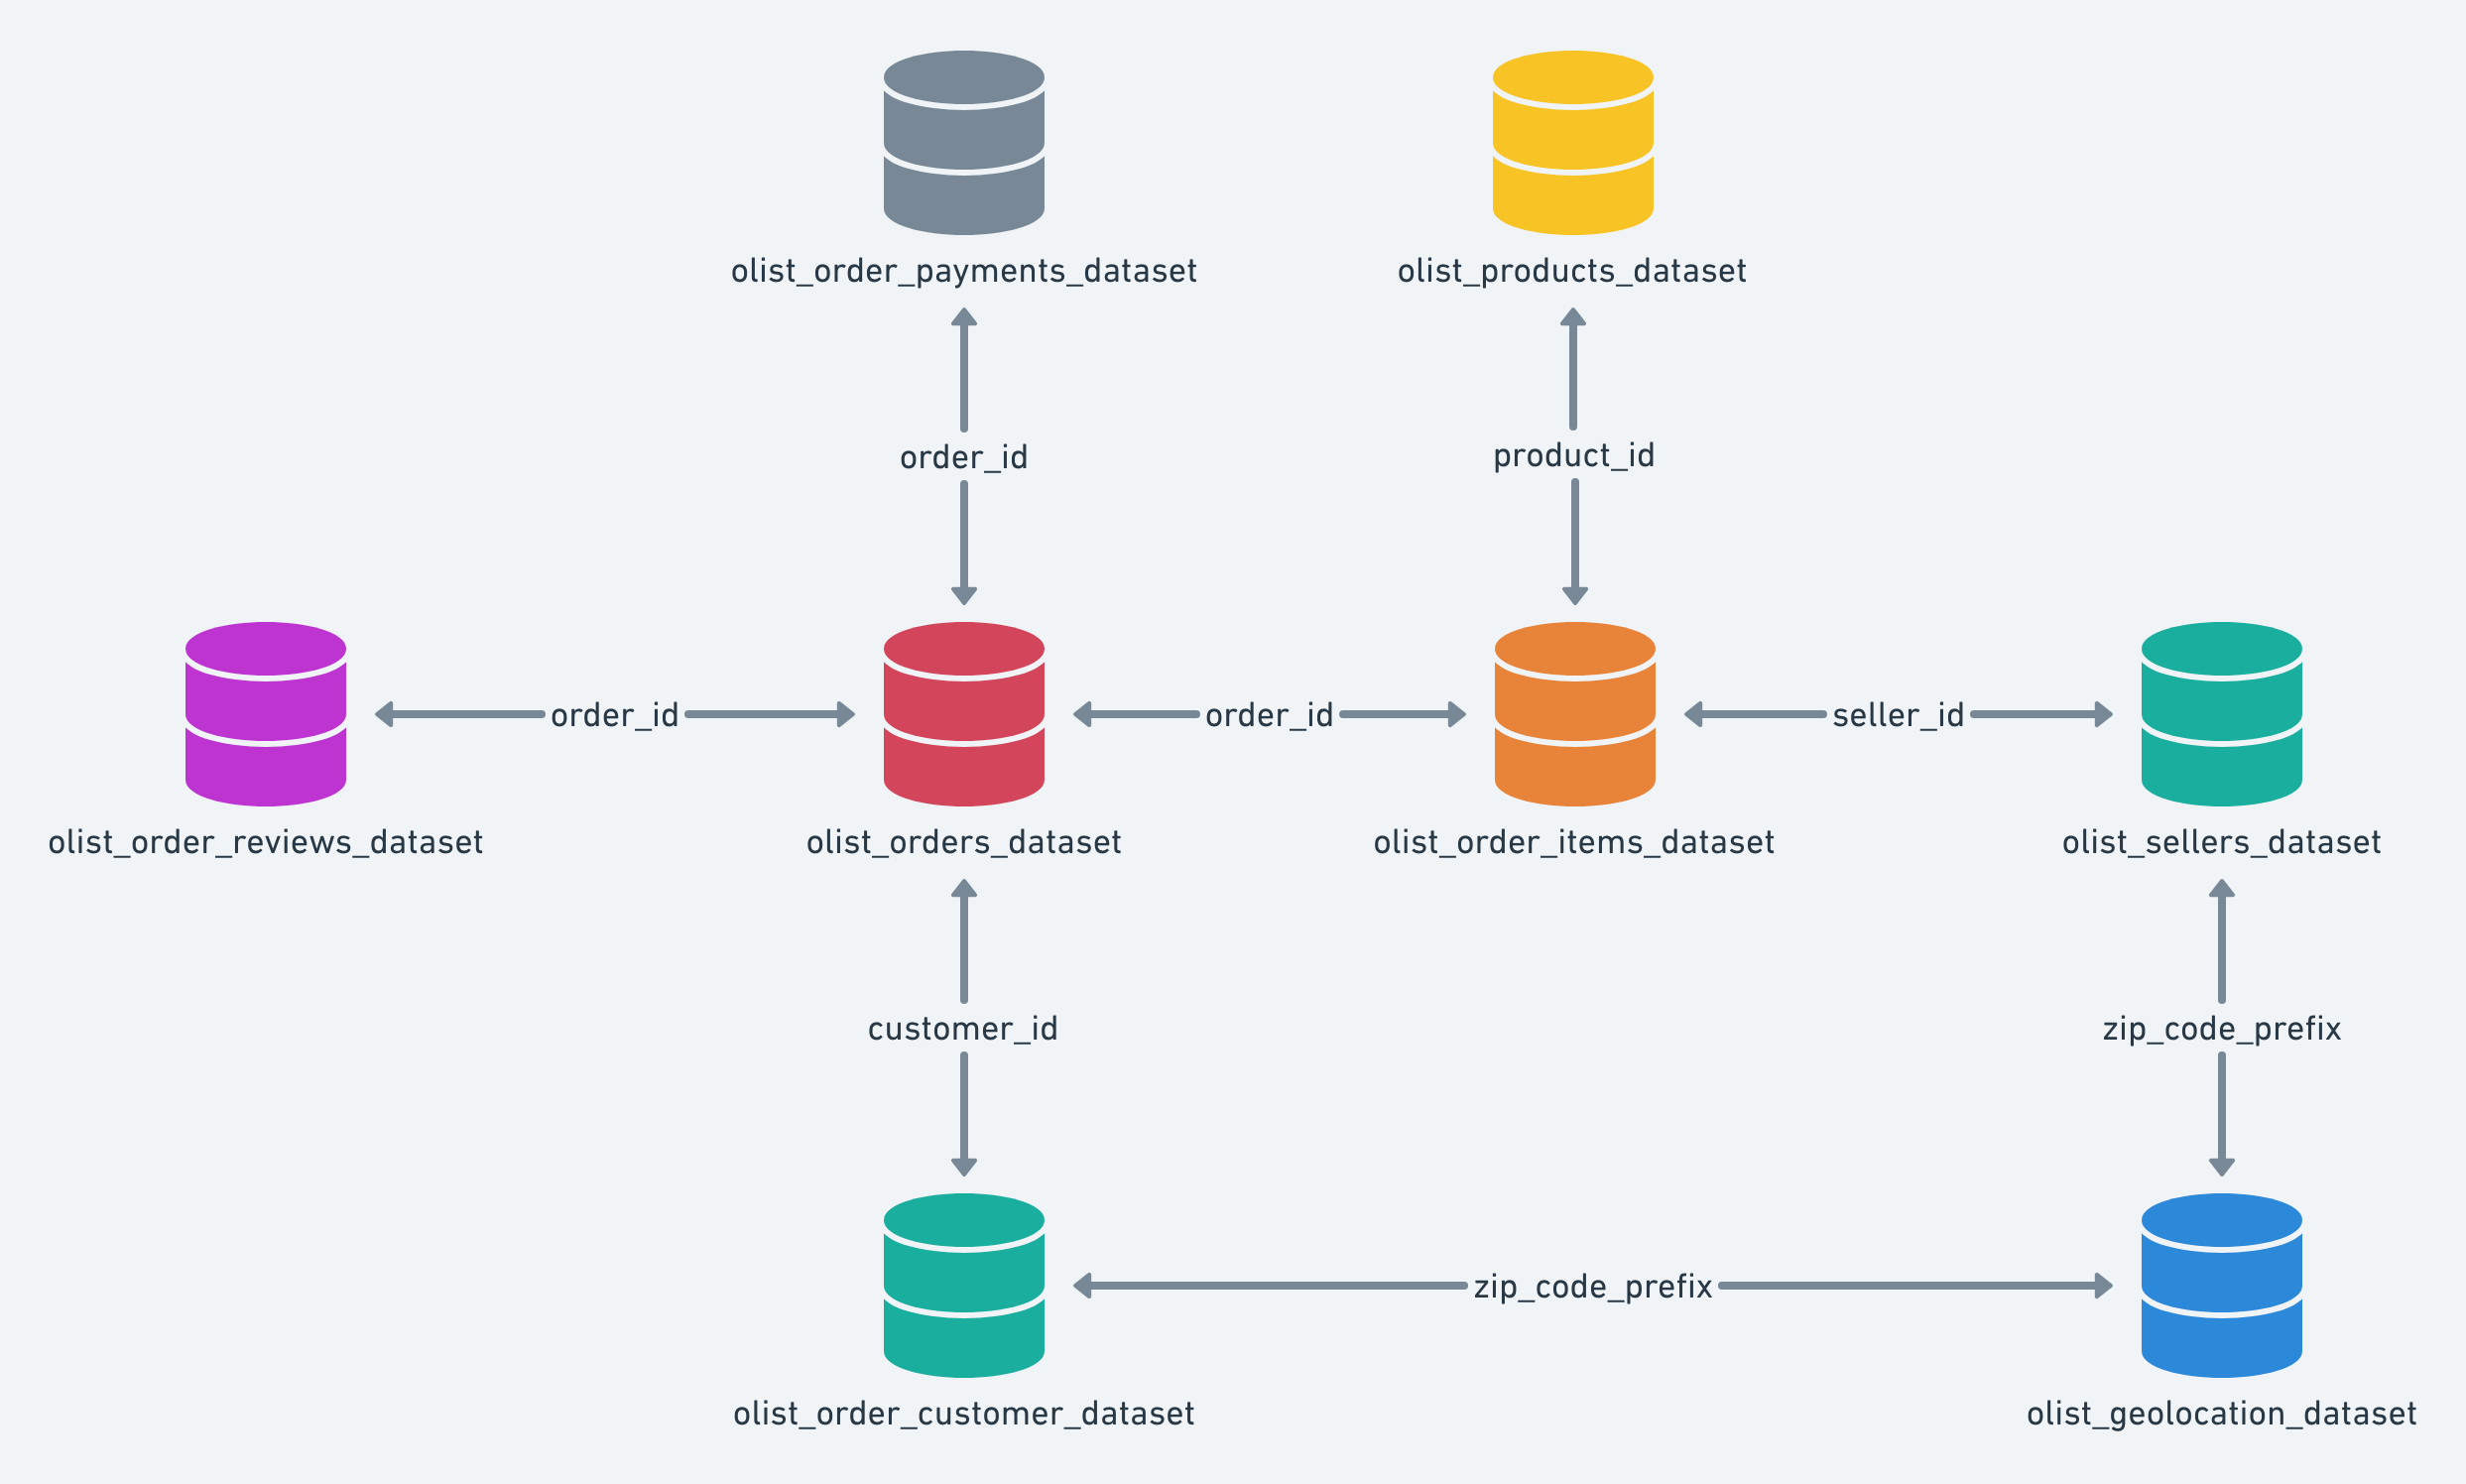

## **Goals**
1. Predict sales
2. How customer reviews affect sales
3. Generate a score and rank for products based on potential for most sales

Based on the available documentation, for goal 1 orders and order_payment dataset are needed. <br> 

For goal 2, order and order_reviews datasets are required.

## Data Analysis & Cleaning

#### Custom Functions For Data Analysis 

In [ ]:
def unique_values(df):
  """
  This function gets the number of unique values per column of the dataframe.

  Arguments:
    df (pandas dataframe): Input pandas dataframe.

  Returns:
    response (list): List of tuples with column name and associated unique
                     value count. 
  """

  response = []
  cols = df.columns
  for col in cols:
    response.append((col, len(df[col].unique())))

  return response

In [ ]:
FILE_PATH = '/content/drive/MyDrive/Data Mining/olist_data/'

def analyze_data(file_name):
  """
  Function to load dataset and perform series of operation on the dataset.

  Arguments:
    file_name (string): dataset file name

  Returns:
    df (dataframe): Pandas dataframe
  """

  complete_file_path = FILE_PATH + file_name

  # creating dataframe 
  df = pd.read_csv(complete_file_path)
  
  print('Shape of the dataset')
  print(df.shape)
  print('----------------------------\n')
  
  print('Uniques values per column')
  pprint(unique_values(df))
  print('----------------------------\n')
  
  print('Duplicate Records')
  pprint(df[df.duplicated()].shape)
  print('----------------------------\n')

  # if duplicate records are present then remove them
  if df[df.duplicated()].shape[0] > 0:
    print(f'Dataset has {df[df.duplicated()].shape[0]} duplicate records.')
    df = df[~df.duplicated()]
    print('Duplicate records have been removed.')
    print('----------------------------\n')

  print('Checking for Null values')
  print(df.isna().sum())
  print('----------------------------\n')
  return df

### 1. Analyzing & Preparing Orders Dataset

In [ ]:
orders = analyze_data('orders.csv')

Shape of the dataset
(99441, 8)
----------------------------

Uniques values per column
[('order_id', 99441),
 ('customer_id', 99441),
 ('order_status', 8),
 ('order_purchase_timestamp', 98875),
 ('order_approved_at', 90734),
 ('order_delivered_carrier_date', 81019),
 ('order_delivered_customer_date', 95665),
 ('order_estimated_delivery_date', 459)]
----------------------------

Duplicate Records
(0, 8)
----------------------------

Checking for Null values
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64
----------------------------



**Observations:**
1. Null values are there, but these are in those columns that are not useful in achieving project goals. <br> Therefore, null value processing is not required.
2. There are no duplicate records.
<br>

With this data, we can get to know about the sales count over the period.


**Sample Orders Data**

In [ ]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


From the above dataset only 3 columns are important from analysis point of view. So, we will be dropping all the remaining columns.

In [ ]:
orders.drop(['order_status', 'order_approved_at',
             'order_delivered_carrier_date',
             'order_delivered_customer_date', 'order_estimated_delivery_date'],
            axis=1, inplace=True)

In [ ]:
orders.rename(columns={'order_purchase_timestamp':'ord_timestamp'},inplace=True)
orders.head()

,order_id,customer_id,ord_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39


**Getting Sales Period**

In [ ]:
print(f"First order timestamp: {orders['ord_timestamp'].min()}")
print(f"Latest order timestamp: {orders['ord_timestamp'].max()}")

First order timestamp: 2016-09-04 21:15:19
Latest order timestamp: 2018-10-17 17:30:18


Creating new column 'order_purchase_yr_month' to better analyze sales over period.

In [ ]:
orders['ord_date'] = orders['ord_timestamp'].apply(lambda x: x[:10])
orders['ord_yr_month'] = orders['ord_timestamp'].apply(lambda x: x[:7])
orders['ord_yr'] = orders['ord_timestamp'].apply(lambda x: x[:4])
orders[['order_id','ord_timestamp','ord_date', 'ord_yr_month', 'ord_yr']].head()

,order_id,ord_timestamp,ord_date,ord_yr_month,ord_yr
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10-02,2017-10,2017
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-07-24,2018-07,2018
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08-08,2018-08,2018
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-11-18,2017-11,2017
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2018-02-13,2018-02,2018


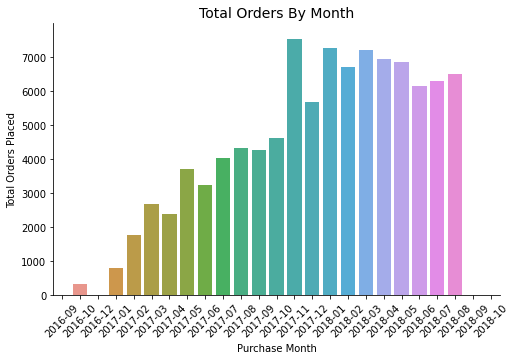

In [ ]:
sales_by_month = sns.barplot(x='ord_yr_month', y='order_id',
                             data = orders.groupby(
                                 'ord_yr_month'
                                 )[['order_id']].count().reset_index())
sales_by_month.tick_params(axis='x', rotation=45)
sales_by_month.set_xlabel('Purchase Month')
sales_by_month.set_ylabel('Total Orders Placed')
sales_by_month.set_title('Total Orders By Month', fontsize=14)
sales_by_month.set_ylim(0,7999)
sales_by_month.figure.set_size_inches((8,5))
sales_by_month.spines['right'].set_visible(False)
sales_by_month.spines['top'].set_visible(False)
sales_by_month.grid(which='minor')

* From above bar chart we can observe that from september 2016 to october 2018, <br>the sales have increased.
* Increase in sales indicate that customers had good experience and may have<br> given good feedback. However, to confirm this customer review dataset needs to be analyzed. 
* Increase in sales also indicates that many customers may have repurchased as <br>well. But in order to draw conclusion on this we need to analyze customers <br>dataset.
<br>
<br>

---


### 2. Analyzing Customers Dataset


---

In [ ]:
customers = analyze_data('customers.csv')

Shape of the dataset
(99441, 5)
----------------------------

Uniques values per column
[('customer_id', 99441),
 ('customer_unique_id', 96096),
 ('customer_zip_code_prefix', 14994),
 ('customer_city', 4119),
 ('customer_state', 27)]
----------------------------

Duplicate Records
(0, 5)
----------------------------

Checking for Null values
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64
----------------------------



**Observations:**
1. There are no null values
2. There are no duplicate records
3. Customer ids are more than unique customer ids. This indicates that there are 1 or more than 1 customer id associated with every unique customer id.

Considering observation 3, we can also get to know how many customers purchased again. <br> <br>

**Sample Customers Data**

In [ ]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


Calculating number of customer ids per unique customer id.

In [ ]:
cust_count = customers.groupby('customer_unique_id')[
  ['customer_unique_id']].count().rename(
      columns={'customer_unique_id':'count'}).reset_index()
cust_count.head()

,customer_unique_id,count
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


Grouping Customers

In [ ]:
def cust_grps(count):
  group = 'One Time Buyer'
  if count > 1:
    group = 'Regular Buyer'
  return group

cust_count['cust_group'] = cust_count['count'].apply(cust_grps)
cust_count.head() 

,customer_unique_id,count,cust_group
0,0000366f3b9a7992bf8c76cfdf3221e2,1,One Time Buyer
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,One Time Buyer
2,0000f46a3911fa3c0805444483337064,1,One Time Buyer
3,0000f6ccb0745a6a4b88665a16c9f078,1,One Time Buyer
4,0004aac84e0df4da2b147fca70cf8255,1,One Time Buyer


**Creating Final Structured Dataframe**

The final dataset will have all the required columns from all the datasets that are essential for final modelling. 

In [ ]:
final_data = pd.merge(orders, pd.merge(customers, cust_count, on='customer_unique_id'), on='customer_id')

In [ ]:
final_data.drop(['count'], axis=1, inplace=True)
final_data.head()

,order_id,customer_id,ord_timestamp,ord_date,ord_yr_month,ord_yr,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,cust_group
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02,2017-10,2017,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,Regular Buyer
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-07-24,2018-07,2018,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,One Time Buyer
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-08,2018-08,2018,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,One Time Buyer
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017-11-18,2017-11,2017,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,One Time Buyer
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018-02-13,2018-02,2018,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,One Time Buyer


In [ ]:
final_data.shape

(99441, 11)

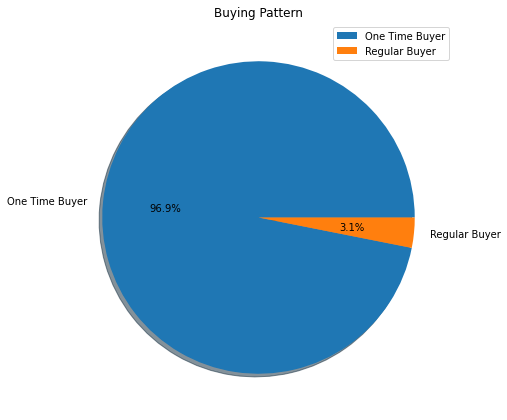

In [ ]:
cust_grps = cust_count.groupby('cust_group')[['cust_group']].count().rename(
    columns={'cust_group':'group_count'})
pie_plot = cust_grps.plot.pie(y='group_count', autopct="%.1f%%", shadow=True)
pie_plot.set_ylabel('')
pie_plot.set_title('Buying Pattern')
pie_plot.figure.set_size_inches((7,9))

* From above pie chart we can observe that there are very few customers that repurchased. <br> Most of the customers bought once only.
* This indicates that most of the customers were not quite satisfied with the order they placed. <br> But in order to verify this, further analysis needs to be done.
* For this purpose analysis of customer review dataset is required.
<br>


---


### 3. Analyzing Order Reviews Dataset


---



In [ ]:
order_reviews = analyze_data('order_reviews.csv')   

Shape of the dataset
(100000, 7)
----------------------------

Uniques values per column
[('review_id', 99173),
 ('order_id', 99441),
 ('review_score', 5),
 ('review_comment_title', 4601),
 ('review_comment_message', 36922),
 ('review_creation_date', 637),
 ('review_answer_timestamp', 99010)]
----------------------------

Duplicate Records
(0, 7)
----------------------------

Checking for Null values
review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64
----------------------------



**Observations:**
1. Count of **review ids is slightly less than total orders**.<br> This needs to be investigated before performing any deletions. 
2. The **count of order ids and review ids is slightly less than total number of records** in the dataset. What relationship exists between review id and order id, that needs to be investigated as well.
3. There are no duplicate records
4. There are many records with null values for comment title and comment<br> message. But, since all the records have a review score, therefore we cannot delete any record.


**Investigating Less Review Count & Relationship Between Review Id and Order Id**
<br>
Getting order ids with count more than 1.

In [ ]:
order_reviews['order_id'].value_counts()

8e17072ec97ce29f0e1f111e598b0c85    3
03c939fd7fd3b38f8485a0f95798f1f6    3
df56136b8031ecd28e200bb18e6ddb2e    3
c88b1d1b157a9999ce368f218a407141    3
02e0b68852217f5715fb9cc885829454    2
                                   ..
6299705212aa08256a85fb33aecfa7ac    1
652dd1e43c57c5f82622cd0d4ec1c376    1
07b3fa22681348d67c91811d31b60e69    1
6d669b4dec428bc8362a8b39ed61aaae    1
4e007faa0b64196f3b99b484f462e2f1    1
Name: order_id, Length: 99441, dtype: int64

Sample data for order ids with count more than 1.

In [ ]:
order_reviews[(order_reviews['order_id']=='03c939fd7fd3b38f8485a0f95798f1f6')| 
              (order_reviews['order_id']=='8e17072ec97ce29f0e1f111e598b0c85')]

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
8329,b04ed893318da5b863e878cd3d0511df,03c939fd7fd3b38f8485a0f95798f1f6,3,NaN,Um ponto negativo que achei foi a cobrança de ...,2018-03-20 00:00:00,2018-03-21 02:28:23
45043,67c2557eb0bd72e3ece1e03477c9dff5,8e17072ec97ce29f0e1f111e598b0c85,1,NaN,Entregou o produto errado.,2018-04-07 00:00:00,2018-04-08 22:48:27
51931,f4bb9d6dd4fb6dcc2298f0e7b17b8e1e,03c939fd7fd3b38f8485a0f95798f1f6,4,NaN,NaN,2018-03-29 00:00:00,2018-03-30 00:29:09
65024,2d6ac45f859465b5c185274a1c929637,8e17072ec97ce29f0e1f111e598b0c85,1,NaN,Comprei 3 unidades do produto vieram 2 unidade...,2018-04-07 00:00:00,2018-04-07 21:13:05
70005,405eb2ea45e1dbe2662541ae5b47e2aa,03c939fd7fd3b38f8485a0f95798f1f6,3,NaN,Seria ótimo se tivesem entregue os 3 (três) pe...,2018-03-06 00:00:00,2018-03-06 19:50:32
93027,6e4c4086d9611ae4cc0cc65a262751fe,8e17072ec97ce29f0e1f111e598b0c85,1,NaN,"Embora tenha entregue dentro do prazo, não env...",2018-04-14 00:00:00,2018-04-16 11:37:31


We can observe from above sample data that for a given order id, there can be more than 1 review ids associated with it.<br><br>
Getting review ids with count more than 1.

In [ ]:
order_reviews['review_id'].value_counts()

32415bbf6e341d5d517080a796f79b5c    3
9e25d6e3025e9b9a0fc7f03588d33e2b    3
4219a80ab469e3fc9901437b73da3f75    3
0c76e7a547a531e7bf9f0b99cba071c1    3
ddc52555ca27b0fe67d5255147682d2d    3
                                   ..
200378d1b4f7d6a6043461eae00f4bba    1
50bff1ee915bf24dc46b5cecc839ddfd    1
a65a633d540b1c3fd54c79bf3aaec84e    1
6535e86c70c05f5f6ff3ed8fb2fc3011    1
e9edd7779fc2ca768d94b836b3f673b2    1
Name: review_id, Length: 99173, dtype: int64

Sample data for review ids with count more than 1.

In [ ]:
order_reviews[(order_reviews['review_id']=='2172867fd5b1a55f98fe4608e1547b4b')| 
              (order_reviews['review_id']=='4d0e6dd087008d1f992d25ef6e1f619f')]

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
7708,4d0e6dd087008d1f992d25ef6e1f619f,d415e95816c2f3a2a34e06cd519157cc,4,NaN,NaN,2018-06-12 00:00:00,2018-06-17 23:48:04
15243,2172867fd5b1a55f98fe4608e1547b4b,559d606ac642899e44550f194fec7e08,5,NaN,Entrega no prazo e produto de qualidade!,2018-02-15 00:00:00,2018-02-26 15:53:18
15583,4d0e6dd087008d1f992d25ef6e1f619f,cd0343141ac675cd40fab2c7fd2e99cc,4,NaN,NaN,2018-06-12 00:00:00,2018-06-17 23:48:04
28806,2172867fd5b1a55f98fe4608e1547b4b,ac6e61336e852cdc45fe59ada3763a66,5,NaN,Entrega no prazo e produto de qualidade!,2018-02-15 00:00:00,2018-02-26 15:53:18
50598,4d0e6dd087008d1f992d25ef6e1f619f,97f95535ada31d6fa853230e815ee4e3,4,NaN,NaN,2018-06-12 00:00:00,2018-06-17 23:48:04
54384,2172867fd5b1a55f98fe4608e1547b4b,e11ba7fd8fe0728dcd89efddcda9fb11,5,NaN,Entrega no prazo e produto de qualidade!,2018-02-15 00:00:00,2018-02-26 15:53:18


As we can see, review id is not unique and can be associated with more than one order ids. Also, we observe that review score, review title and review message is same for a review id, even if there are different order ids associated. 
<br><br>
The relationship of review id and order id can be visualized as below.

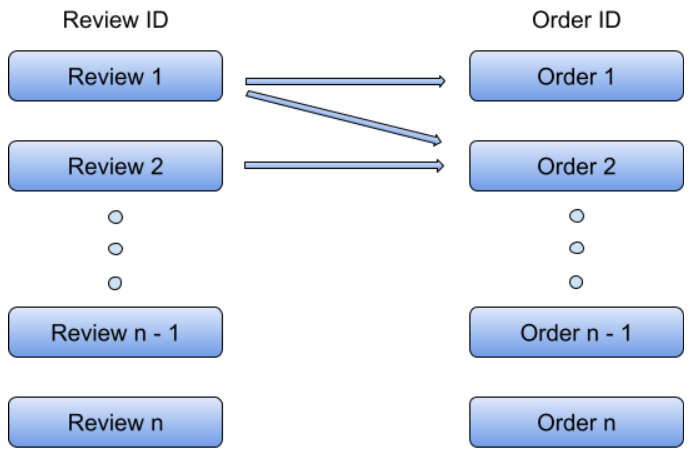

**Calculating count of Order IDs with 1 Review ID**  

In [ ]:
sample_data = order_reviews.groupby(
    'order_id')[['review_id']].count().rename(
        columns={'review_id':'review_count'}).reset_index()

In [ ]:
sample_data[sample_data['review_count']==1].shape

(98886, 2)

**Calculating count of Review IDs with 1 Order ID**  

In [ ]:
sample_data = order_reviews.groupby(
    'review_id')[['order_id']].count().rename(
        columns={'order_id':'order_count'}).reset_index()

In [ ]:
sample_data[sample_data['order_count']==1].shape

(98371, 2)

In [ ]:
del sample_data

**Investigation Result**


1. Total records: 100,000
2. Orders with only 1 review: 98,886
3. Reviews for only 1 order: 98,371
4. Records with strictly one to one relationship: 98,886 + 98,371 - 100,000 = 97,257
5. 2,743 (100,000 - 97,257) records have many to many relationship between order id and review id. **This is only 2.7% of the total records**, so it will not affect the overall analysis.


**Removing redundant columns from order reviews dataset**

In [ ]:
order_reviews.drop(columns=['review_creation_date',
                            'review_answer_timestamp',
                            'review_comment_title',
                            'review_comment_message'], inplace=True)
order_reviews.head()

,review_id,order_id,review_score
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5


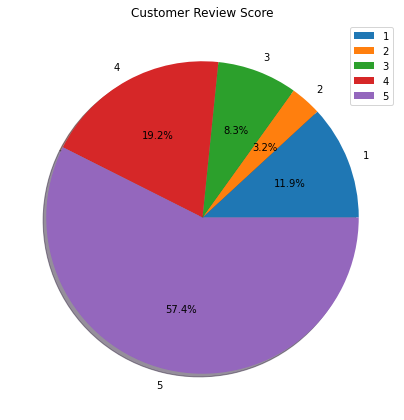

In [ ]:
review_plot = order_reviews.groupby(
    'review_score')[['review_score']].count().plot.pie(y='review_score',
                                                       autopct="%.1f%%",
                                                       shadow=True)
review_plot.set_ylabel('')
review_plot.set_title('Customer Review Score')
review_plot.figure.set_size_inches((7,9))

**Updating Final Dataset**

Joining order reviews dataset with final dataset.

In [ ]:
final_data = pd.merge(final_data, order_reviews, on='order_id')

In [ ]:
final_data.head()

,order_id,customer_id,ord_timestamp,ord_date,ord_yr_month,ord_yr,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,cust_group,review_id,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02,2017-10,2017,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,Regular Buyer,a54f0611adc9ed256b57ede6b6eb5114,4
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-07-24,2018-07,2018,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,One Time Buyer,8d5266042046a06655c8db133d120ba5,4
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-08,2018-08,2018,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,One Time Buyer,e73b67b67587f7644d5bd1a52deb1b01,5
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017-11-18,2017-11,2017,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,One Time Buyer,359d03e676b3c069f62cadba8dd3f6e8,5
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018-02-13,2018-02,2018,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,One Time Buyer,e50934924e227544ba8246aeb3770dd4,5


In [ ]:
final_data.shape

(100000, 13)

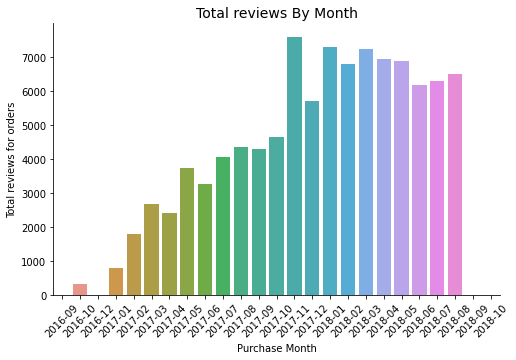

In [ ]:
reviews_by_month = sns.barplot(x='ord_yr_month', y='review_id',
                             data = final_data.groupby(
                                 'ord_yr_month'
                                 )[['review_id']].count().reset_index())
reviews_by_month.tick_params(axis='x', rotation=45)
reviews_by_month.set_xlabel('Purchase Month')
reviews_by_month.set_ylabel('Total reviews for orders')
reviews_by_month.set_title('Total reviews By Month', fontsize=14)
reviews_by_month.set_ylim(0,7999)
reviews_by_month.figure.set_size_inches((8,5))
reviews_by_month.spines['right'].set_visible(False)
reviews_by_month.spines['top'].set_visible(False)
reviews_by_month.grid(which='minor')

In [ ]:
sample_df = final_data
sample_df['c'] = sample_df['review_score'].apply(lambda x:1)
print(sample_df.head())

                           order_id  ...  c
0  e481f51cbdc54678b7cc49136f2d6af7  ...  1
1  53cdb2fc8bc7dce0b6741e2150273451  ...  1
2  47770eb9100c2d0c44946d9cf07ec65d  ...  1
3  949d5b44dbf5de918fe9c16f97b45f8a  ...  1
4  ad21c59c0840e6cb83a9ceb5573f8159  ...  1

[5 rows x 14 columns]


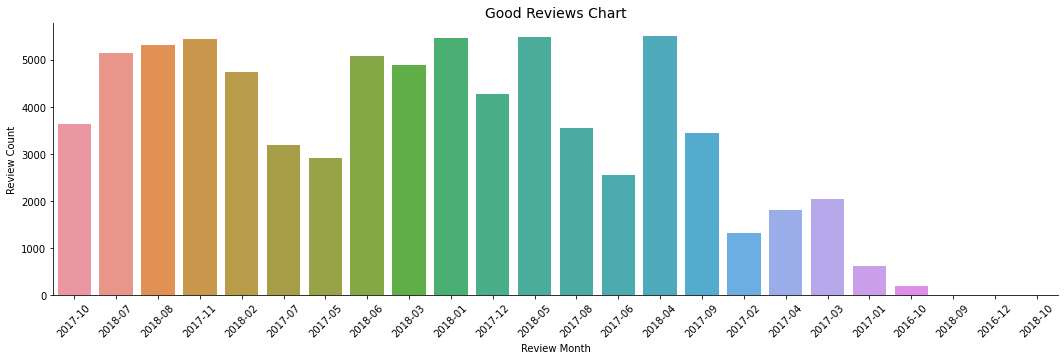

In [ ]:
reviews_month = sns.barplot(x='ord_yr_month', y='c', data=sample_df[
  (sample_df['review_score']==5)|(sample_df['review_score']==4)], ci=2, estimator=sum)
reviews_month.tick_params(axis='x', rotation=45)
reviews_month.set_xlabel('Review Month')
reviews_month.set_ylabel('Review Count')
reviews_month.set_title('Good Reviews Chart', fontsize=14)
reviews_month.figure.set_size_inches((18,5))
reviews_month.spines['right'].set_visible(False)
reviews_month.spines['top'].set_visible(False)
reviews_month.grid(which='minor')

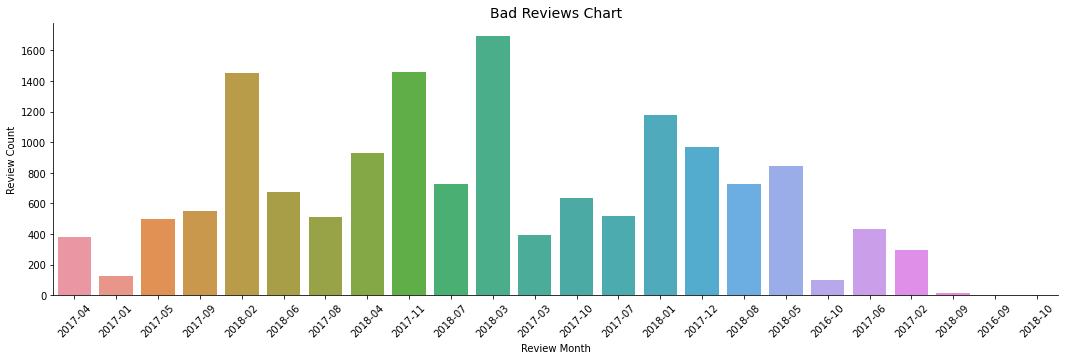

In [ ]:
reviews_month = sns.barplot(x='ord_yr_month', y='c', data=sample_df[
  (sample_df['review_score']==1)|(sample_df['review_score']==2)], ci=2, estimator=sum)
reviews_month.tick_params(axis='x', rotation=45)
reviews_month.set_xlabel('Review Month')
reviews_month.set_ylabel('Review Count')
reviews_month.set_title('Bad Reviews Chart', fontsize=14)
reviews_month.figure.set_size_inches((18,5))
reviews_month.spines['right'].set_visible(False)
reviews_month.spines['top'].set_visible(False)
reviews_month.grid(which='minor')

---


### 4. Analyzing Order Items Dataset


---

In [ ]:
order_items = analyze_data('order_items.csv')

Shape of the dataset
(112650, 7)
----------------------------

Uniques values per column
[('order_id', 98666),
 ('order_item_id', 21),
 ('product_id', 32951),
 ('seller_id', 3095),
 ('shipping_limit_date', 93318),
 ('price', 5968),
 ('freight_value', 6999)]
----------------------------

Duplicate Records
(0, 7)
----------------------------

Checking for Null values
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64
----------------------------



**Observations:**
1. There are no null values 
2. There are no duplicate records
3. Count of unique order ids less than total records indicates that there are many<br> orders with more than 1 item.


**Sample Order Items Data**

In [ ]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [ ]:
 order_items.drop(columns=['seller_id', 'shipping_limit_date'], inplace=True)

In [ ]:
order_items.head()

,order_id,order_item_id,product_id,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,199.90,18.14


In [ ]:
item_count = order_items.groupby('order_id')[['order_id']].count().rename(
    columns={'order_id':'items_count'}).reset_index()
item_count[item_count['items_count']>15]

,order_id,items_count
10459,1b15974a0141d54e36626dca3fdc731a,20
50137,8272b63d03f5f79c56e9e4120aec44ef,21
65715,ab14fdcfbe524636d65ee38360e22ce8,20


The above dataframe shows orders with more than 15 items.<br>
To generalize, every order has 1 or more than 1 item, and every item has a product id asociated with it.<br><br>
**Analyzing Final Dataset & Order Items Dataset Further Before Joining**

In [ ]:
final_data.shape

(100000, 14)

In [ ]:
sample_data = pd.merge(final_data, order_items, on='order_id', how='right')

In [ ]:
sample_data.shape

(113322, 18)

In [ ]:
sample_data[sample_data.duplicated()].shape

(0, 18)

In [ ]:
sample_data.isna().sum()

order_id                    0
customer_id                 0
ord_timestamp               0
ord_date                    0
ord_yr_month                0
ord_yr                      0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
cust_group                  0
review_id                   0
review_score                0
c                           0
order_item_id               0
product_id                  0
price                       0
freight_value               0
dtype: int64

In [ ]:
sample_data = pd.merge(final_data, order_items, on='order_id', how='left')

In [ ]:
sample_data.shape

(114100, 18)

In [ ]:
sample_data[sample_data.duplicated()].shape

(0, 18)

In [ ]:
sample_data.isna().sum()

order_id                      0
customer_id                   0
ord_timestamp                 0
ord_date                      0
ord_yr_month                  0
ord_yr                        0
customer_unique_id            0
customer_zip_code_prefix      0
customer_city                 0
customer_state                0
cust_group                    0
review_id                     0
review_score                  0
c                             0
order_item_id               778
product_id                  778
price                       778
freight_value               778
dtype: int64

In [ ]:
del sample_data

From above analysis, we can see that there are some order ids whose data is not present in order items dataset, and therfore when we are using a RIGHT JOIN or INNER JOIN, then there is some loss of data.<br> <br>
So, in this case we will be using LEFT JOIN to update the final dataset.
<br><br>

**Updating Final Dataset**

In [ ]:
final_data = pd.merge(final_data, order_items, on='order_id', how='left')

In [ ]:
final_data.head()

,order_id,customer_id,ord_timestamp,ord_date,ord_yr_month,ord_yr,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,cust_group,review_id,review_score,c,order_item_id,product_id,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02,2017-10,2017,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,Regular Buyer,a54f0611adc9ed256b57ede6b6eb5114,4,1,1.0,87285b34884572647811a353c7ac498a,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-07-24,2018-07,2018,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,One Time Buyer,8d5266042046a06655c8db133d120ba5,4,1,1.0,595fac2a385ac33a80bd5114aec74eb8,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-08,2018-08,2018,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,One Time Buyer,e73b67b67587f7644d5bd1a52deb1b01,5,1,1.0,aa4383b373c6aca5d8797843e5594415,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017-11-18,2017-11,2017,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,One Time Buyer,359d03e676b3c069f62cadba8dd3f6e8,5,1,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018-02-13,2018-02,2018,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,One Time Buyer,e50934924e227544ba8246aeb3770dd4,5,1,1.0,65266b2da20d04dbe00c5c2d3bb7859e,19.90,8.72




---

### 5. Analyzing Geolocation Data


---



In [ ]:
geolocation = analyze_data('geolocation.csv')

Shape of the dataset
(1000163, 5)
----------------------------

Uniques values per column
[('geolocation_zip_code_prefix', 19015),
 ('geolocation_lat', 717358),
 ('geolocation_lng', 717613),
 ('geolocation_city', 8011),
 ('geolocation_state', 27)]
----------------------------

Duplicate Records
(261831, 5)
----------------------------

Dataset has 261831 duplicate records.
Duplicate records have been removed.
----------------------------

Checking for Null values
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64
----------------------------



In [ ]:
geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


Geolocation data has longitude and latitude information of different cities of Brazil. <br>
As far as the goal of this project is concerned, this information will not be useful. So, therefore this data will not be used for analysis.


---

### 6. Analyzing Product Category Name Translation Dataset


---



In [ ]:
product_category_name_translation = analyze_data('product_category_name_translation.csv')

Shape of the dataset
(71, 2)
----------------------------

Uniques values per column
[('product_category_name', 71), ('product_category_name_english', 71)]
----------------------------

Duplicate Records
(0, 2)
----------------------------

Checking for Null values
product_category_name            0
product_category_name_english    0
dtype: int64
----------------------------



**Observations:**
1. There are no null values. 
2. There are no duplicate records.
3. This data is good and does not requires any kind of processing.


**Top 5 Records**

In [ ]:
product_category_name_translation.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


---

### 7. Analyzing Products Dataset


---

In [ ]:
products = analyze_data('products.csv')

Shape of the dataset
(32951, 9)
----------------------------

Uniques values per column
[('product_id', 32951),
 ('product_category_name', 74),
 ('product_name_lenght', 67),
 ('product_description_lenght', 2961),
 ('product_photos_qty', 20),
 ('product_weight_g', 2205),
 ('product_length_cm', 100),
 ('product_height_cm', 103),
 ('product_width_cm', 96)]
----------------------------

Duplicate Records
(0, 9)
----------------------------

Checking for Null values
product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64
----------------------------



In [ ]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


**Dropping Redundant Columns**

In [ ]:
products = products[['product_id', 'product_category_name']]
products.head()

,product_id,product_category_name
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria
1,3aa071139cb16b67ca9e5dea641aaa2f,artes
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer
3,cef67bcfe19066a932b7673e239eb23d,bebes
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas


**Joining Products & Product Category Name Translation Datasets** <br>
The resultant dataset will be then be joined with final dataset.

In [ ]:
products = pd.merge(products, product_category_name_translation, on='product_category_name', how='left')
products = products[['product_id', 'product_category_name_english']]
products.head()

,product_id,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,art
2,96bd76ec8810374ed1b65e291975717f,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,baby
4,9dc1a7de274444849c219cff195d0b71,housewares


**Updating Final Dataset**

In [ ]:
final_data = pd.merge(final_data, products, on='product_id', how='left')

---

### 8. Analyzing Sellers Dataset


---

In [ ]:
sellers = analyze_data('sellers.csv')

Shape of the dataset
(3095, 4)
----------------------------

Uniques values per column
[('seller_id', 3095),
 ('seller_zip_code_prefix', 2246),
 ('seller_city', 611),
 ('seller_state', 23)]
----------------------------

Duplicate Records
(0, 4)
----------------------------

Checking for Null values
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64
----------------------------



**Observations:**
1. There are no null values. 
2. There are no duplicate records.
3. This data is good and does not requires any kind of processing.


**Top 5 Records**

In [ ]:
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


The dataset contains all the information about the sellers, and it appears that nothing in this dataset can be useful for final analysis.<br><br>


---
### 9. Analyzing Order Payments Dataset


---




In [ ]:
order_payments = analyze_data('order_payments.csv')

Shape of the dataset
(103886, 5)
----------------------------

Uniques values per column
[('order_id', 99440),
 ('payment_sequential', 29),
 ('payment_type', 5),
 ('payment_installments', 24),
 ('payment_value', 29077)]
----------------------------

Duplicate Records
(0, 5)
----------------------------

Checking for Null values
order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64
----------------------------



**Observations:**
1. There are no null values. 
2. There are no duplicate records.
3. This data is good and does not requires any kind of processing.


**Top 5 Records**

In [ ]:
order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [ ]:
order_payments[order_payments['order_id'] == '31bc09fdbd701a7a4f9b55b5955b8687']

,order_id,payment_sequential,payment_type,payment_installments,payment_value
27995,31bc09fdbd701a7a4f9b55b5955b8687,3,voucher,1,37.88
39416,31bc09fdbd701a7a4f9b55b5955b8687,7,voucher,1,3.48
43160,31bc09fdbd701a7a4f9b55b5955b8687,4,voucher,1,40.33
45492,31bc09fdbd701a7a4f9b55b5955b8687,1,voucher,1,26.86
74317,31bc09fdbd701a7a4f9b55b5955b8687,5,voucher,1,22.28
82459,31bc09fdbd701a7a4f9b55b5955b8687,2,voucher,1,55.71
103860,31bc09fdbd701a7a4f9b55b5955b8687,6,voucher,1,77.99


After analyzing the order payments dataset, we observe that this dataset contains details about the mode of payment and the installments for a particular order.<br>
The final payment made against an order is already present in order items dataset, so therefore we will not be using this dataset for our analysis.

### Final Structured & Processed Data

In [ ]:
final_data.head()

,order_id,customer_id,ord_timestamp,ord_date,ord_yr_month,ord_yr,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,cust_group,review_id,review_score,c,order_item_id,product_id,price,freight_value,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02,2017-10,2017,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,Regular Buyer,a54f0611adc9ed256b57ede6b6eb5114,4,1,1.0,87285b34884572647811a353c7ac498a,29.99,8.72,housewares
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-07-24,2018-07,2018,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,One Time Buyer,8d5266042046a06655c8db133d120ba5,4,1,1.0,595fac2a385ac33a80bd5114aec74eb8,118.70,22.76,perfumery
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-08,2018-08,2018,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,One Time Buyer,e73b67b67587f7644d5bd1a52deb1b01,5,1,1.0,aa4383b373c6aca5d8797843e5594415,159.90,19.22,auto
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017-11-18,2017-11,2017,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,One Time Buyer,359d03e676b3c069f62cadba8dd3f6e8,5,1,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,45.00,27.20,pet_shop
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018-02-13,2018-02,2018,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,One Time Buyer,e50934924e227544ba8246aeb3770dd4,5,1,1.0,65266b2da20d04dbe00c5c2d3bb7859e,19.90,8.72,stationery


In [ ]:
final_data.rename(columns={'customer_id':'cust_id',
                           'customer_unique_id':'cust_unique_id',
                           'customer_zip_code_prefix':'cust_zip_code_prefix',
                           'customer_city':'cust_city',
                           'customer_state':'cust_state',
                           'product_id':'pid',
                           'product_category_name_english':'product_name'},
                  inplace=True)
final_data.head()

,order_id,cust_id,ord_timestamp,ord_date,ord_yr_month,ord_yr,cust_unique_id,cust_zip_code_prefix,cust_city,cust_state,cust_group,review_id,review_score,c,order_item_id,pid,price,freight_value,product_name
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02,2017-10,2017,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,Regular Buyer,a54f0611adc9ed256b57ede6b6eb5114,4,1,1.0,87285b34884572647811a353c7ac498a,29.99,8.72,housewares
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-07-24,2018-07,2018,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,One Time Buyer,8d5266042046a06655c8db133d120ba5,4,1,1.0,595fac2a385ac33a80bd5114aec74eb8,118.70,22.76,perfumery
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-08,2018-08,2018,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,One Time Buyer,e73b67b67587f7644d5bd1a52deb1b01,5,1,1.0,aa4383b373c6aca5d8797843e5594415,159.90,19.22,auto
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017-11-18,2017-11,2017,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,One Time Buyer,359d03e676b3c069f62cadba8dd3f6e8,5,1,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,45.00,27.20,pet_shop
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018-02-13,2018-02,2018,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,One Time Buyer,e50934924e227544ba8246aeb3770dd4,5,1,1.0,65266b2da20d04dbe00c5c2d3bb7859e,19.90,8.72,stationery


## **Goal 1: Predict Sales**

---



In [ ]:
required_data = final_data[['ord_date', 'price']]
required_data = required_data.groupby('ord_date')[['price']].sum().reset_index()

In [ ]:
required_data.head()

,ord_date,price
0,2016-09-04,72.89
1,2016-09-05,59.50
2,2016-09-13,0.00
3,2016-09-15,134.97
4,2016-10-02,100.00


In [ ]:
required_data.shape

(634, 2)

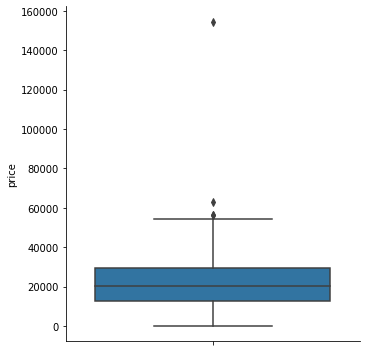

In [ ]:
sns.catplot(y='price', data=required_data, kind='box')
plt.show()

We observe that there are some outliers. So we will remove the records where total sales is more that 60,000.

In [ ]:
required_data = required_data[required_data['price']<60000].iloc[:615]

In [ ]:
required_data.shape

(615, 2)

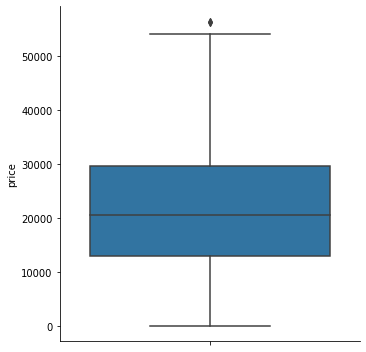

In [ ]:
sns.catplot(y='price', data=required_data, kind='box')
plt.show()

In the boxplot shown above we can see that we have been able to remove the outliers successfully.

In [ ]:
print(f"First Order Date: {required_data['ord_date'].min()} \nLast Order Date: {required_data['ord_date'].max()}")

First Order Date: 2016-09-04 
Last Order Date: 2018-08-29


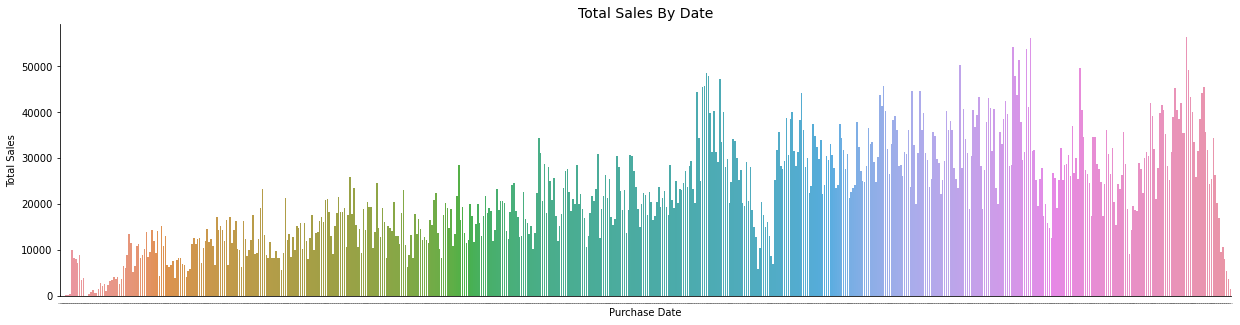

In [ ]:
sales_by_month = sns.barplot(x='ord_date', y='price',
                             data = required_data.groupby(
                                 'ord_date')[['price']].sum().reset_index())
sales_by_month.tick_params(axis='x', labelsize=0, width=0)
sales_by_month.set_xlabel('Purchase Date')
sales_by_month.set_ylabel('Total Sales')
sales_by_month.set_title('Total Sales By Date', fontsize=14)
#sales_by_month.set_ylim(0,9800)
sales_by_month.figure.set_size_inches((21,5))
sales_by_month.spines['right'].set_visible(False)
sales_by_month.spines['top'].set_visible(False)
sales_by_month.grid(which='minor',alpha=0.3)

The above chart shows the total sales on a daily basis from 2016-09-04 to 2018-10-17

In [ ]:
required_data['ord_date'] = pd.to_datetime(required_data['ord_date'])

In [ ]:
required_data.dtypes

ord_date    datetime64[ns]
price              float64
dtype: object

In [ ]:
def sales_duration(data):
    data.ord_date = pd.to_datetime(data.ord_date)
    number_of_days = data.ord_date.max() - data.ord_date.min()
    number_of_years = number_of_days.days / 365
    print(number_of_days.days, 'days')
    print(round(number_of_years, 2), 'years')
    
sales_duration(required_data)

724 days
1.98 years


In [ ]:
# Average daily sales

# Overall
avg_daily_sales = round(required_data.price.mean(), 2)
print(f"Overall average daily sales: ${avg_daily_sales}")

# Last 12 months (this will be the forecasted sales)
avg_daily_sales_120days = round(required_data.price[-120:].mean(), 2)
print(f"Last 120 days average daily sales: ${avg_daily_sales_120days}")

Overall average daily sales: $21846.77
Last 120 days average daily sales: $29850.96


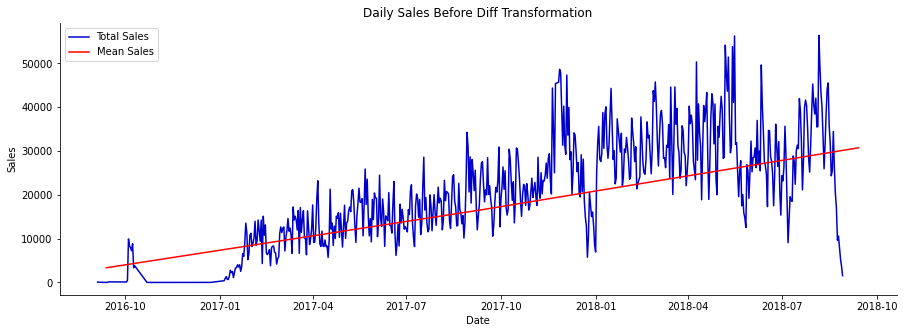

In [ ]:

def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x=x_col, y=y_col, data=data, ax=ax, color='mediumblue', label='Total Sales')
    
    second = data.groupby(data.ord_date.dt.year)[y_col].mean().reset_index()
    second.ord_date = pd.to_datetime(second.ord_date, format='%Y')
    sns.lineplot(x=(second.ord_date + datetime.timedelta(0.70*365)), y=y_col, data=second, ax=ax, color='red', label='Mean Sales')   
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = title)
    
    sns.despine()

time_plot(required_data, 'ord_date', 'price','Daily Sales Before Diff Transformation')

In [ ]:
# Calculate difference in sales day over day
def get_diff(data):
    data['sales_diff'] = data.price.diff()    
    data = data.dropna()      
    return data
stationary_df = get_diff(required_data)

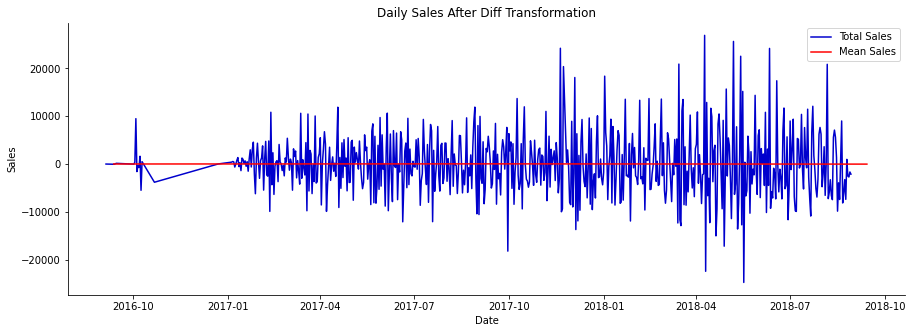

In [ ]:
time_plot(stationary_df, 'ord_date', 'sales_diff', 'Daily Sales After Diff Transformation')

In [ ]:
#create dataframe for transformation from time series to supervised
def generate_supervised(data):
    supervised_df = data.copy()
    
    #create column for each lag
    for i in range(1,121):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['sales_diff'].shift(i)
    
    #drop null values
    supervised_df = supervised_df.dropna().reset_index(drop=True)
    
    return supervised_df

In [ ]:
model_df = generate_supervised(stationary_df)

In [ ]:
model_df.head()

,ord_date,price,sales_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,...,lag_81,lag_82,lag_83,lag_84,lag_85,lag_86,lag_87,lag_88,lag_89,lag_90,lag_91,lag_92,lag_93,lag_94,lag_95,lag_96,lag_97,lag_98,lag_99,lag_100,lag_101,lag_102,lag_103,lag_104,lag_105,lag_106,lag_107,lag_108,lag_109,lag_110,lag_111,lag_112,lag_113,lag_114,lag_115,lag_116,lag_117,lag_118,lag_119,lag_120
0,2017-04-21,8457.71,-5091.42,1362.31,-9099.90,11870.05,3689.71,-2606.98,165.28,-1522.77,1482.23,-87.31,-3435.80,3509.66,-562.44,-4515.56,-9913.24,4165.15,6747.09,3075.09,96.68,-8567.49,5497.81,2173.96,1365.06,-3712.57,-3983.86,10036.02,-3675.09,-181.83,-6197.68,2084.37,2842.25,-5647.56,10447.15,-9784.48,4463.42,-2299.38,-859.45,885.57,...,4343.47,1246.65,-6221.94,-2104.05,4559.77,3022.06,-626.30,2962.20,1093.77,-1510.33,481.88,-478.41,660.93,63.51,958.45,1236.78,-1392.89,271.00,-541.58,1341.29,761.08,-35.79,-642.32,435.52,519.48,386.00,10.90,-3819.26,482.27,-5504.85,1613.79,-732.46,-382.74,-1597.71,9477.48,363.48,-34.97,134.97,-59.50,-13.39
1,2017-04-22,12880.17,4422.46,-5091.42,1362.31,-9099.90,11870.05,3689.71,-2606.98,165.28,-1522.77,1482.23,-87.31,-3435.80,3509.66,-562.44,-4515.56,-9913.24,4165.15,6747.09,3075.09,96.68,-8567.49,5497.81,2173.96,1365.06,-3712.57,-3983.86,10036.02,-3675.09,-181.83,-6197.68,2084.37,2842.25,-5647.56,10447.15,-9784.48,4463.42,-2299.38,-859.45,...,424.99,4343.47,1246.65,-6221.94,-2104.05,4559.77,3022.06,-626.30,2962.20,1093.77,-1510.33,481.88,-478.41,660.93,63.51,958.45,1236.78,-1392.89,271.00,-541.58,1341.29,761.08,-35.79,-642.32,435.52,519.48,386.00,10.90,-3819.26,482.27,-5504.85,1613.79,-732.46,-382.74,-1597.71,9477.48,363.48,-34.97,134.97,-59.50
2,2017-04-23,10038.95,-2841.22,4422.46,-5091.42,1362.31,-9099.90,11870.05,3689.71,-2606.98,165.28,-1522.77,1482.23,-87.31,-3435.80,3509.66,-562.44,-4515.56,-9913.24,4165.15,6747.09,3075.09,96.68,-8567.49,5497.81,2173.96,1365.06,-3712.57,-3983.86,10036.02,-3675.09,-181.83,-6197.68,2084.37,2842.25,-5647.56,10447.15,-9784.48,4463.42,-2299.38,...,-3006.37,424.99,4343.47,1246.65,-6221.94,-2104.05,4559.77,3022.06,-626.30,2962.20,1093.77,-1510.33,481.88,-478.41,660.93,63.51,958.45,1236.78,-1392.89,271.00,-541.58,1341.29,761.08,-35.79,-642.32,435.52,519.48,386.00,10.90,-3819.26,482.27,-5504.85,1613.79,-732.46,-382.74,-1597.71,9477.48,363.48,-34.97,134.97
3,2017-04-24,15150.03,5111.08,-2841.22,4422.46,-5091.42,1362.31,-9099.90,11870.05,3689.71,-2606.98,165.28,-1522.77,1482.23,-87.31,-3435.80,3509.66,-562.44,-4515.56,-9913.24,4165.15,6747.09,3075.09,96.68,-8567.49,5497.81,2173.96,1365.06,-3712.57,-3983.86,10036.02,-3675.09,-181.83,-6197.68,2084.37,2842.25,-5647.56,10447.15,-9784.48,4463.42,...,697.89,-3006.37,424.99,4343.47,1246.65,-6221.94,-2104.05,4559.77,3022.06,-626.30,2962.20,1093.77,-1510.33,481.88,-478.41,660.93,63.51,958.45,1236.78,-1392.89,271.00,-541.58,1341.29,761.08,-35.79,-642.32,435.52,519.48,386.00,10.90,-3819.26,482.27,-5504.85,1613.79,-732.46,-382.74,-1597.71,9477.48,363.48,-34.97
4,2017-04-25,14671.74,-478.29,5111.08,-2841.22,4422.46,-5091.42,1362.31,-9099.90,11870.05,3689.71,-2606.98,165.28,-1522.77,1482.23,-87.31,-3435.80,3509.66,-562.44,-4515.56,-9913.24,4165.15,6747.09,3075.09,96.68,-8567.49,5497.81,2173.96,1365.06,-3712.57,-3983.86,10036.02,-3675.09,-181.83,-6197.68,2084.37,2842.25,-5647.56,10447.15,-9784.48,...,1266.10,697.89,-3006.37,424.99,4343.47,1246.65,-6221.94,-2104.05,4559.77,3022.06,-626.30,2962.20,1093.77,-1510.33,481.88,-478.41,660.93,63.51,958.45,1236.78,-1392.89,271.00,-541.58,1341.29,761.08,-35.79,-642.32,435.52,519.48,386.00,10.90,-3819.26,482.27,-5504.85,1613.79,-732.46,-382.74,-1597.71,9477.48,363.48


In [ ]:
def tts(data):
    data = data.drop(['price','ord_date'],axis=1)
    train, test = data[0:-120].values, data[-120:].values
    
    return train, test

train, test = tts(model_df)

In [ ]:
train.shape

(374, 121)

In [ ]:
test.shape

(120, 121)

In [ ]:
def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)

In [ ]:
y_train.shape

(374,)

In [ ]:
def undo_scaling(y_pred, x_test, scaler_obj):  
    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    
    x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))
        
    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    
    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted

In [ ]:
def predict_df(unscaled_predictions, original_df):
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-121:].ord_date)
    act_sales = list(original_df[-121:].price)
    
    for index in range(0,len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscaled_predictions[index][0] + act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result

In [ ]:
model_scores = {}

def get_scores(unscaled_df, original_df, model_name):
    rmse = np.sqrt(mean_squared_error(original_df.price[-120:], unscaled_df.pred_value[-120:]))
    mae = mean_absolute_error(original_df.price[-120:], unscaled_df.pred_value[-120:])
    r2 = r2_score(original_df.price[-120:], unscaled_df.pred_value[-120:])
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")

In [ ]:
def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x=original_df.ord_date, y=original_df.price, data=original_df, ax=ax, 
                 label='Original', color='mediumblue')
    sns.lineplot(x=results.date, y=results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend()
    sns.despine()

In [ ]:
def run_model(train_data, test_data, model, model_name):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)
    
    # Undo scaling to compare predictions against original data
    original_df = required_data
    unscaled = undo_scaling(predictions, X_test, scaler_object)
    unscaled_df = predict_df(unscaled, original_df)
      
    get_scores(unscaled_df, original_df, model_name)
    
    plot_results(unscaled_df, original_df, model_name)

RMSE: 8024.686734149135
MAE: 6254.150583333326
R2 Score: 0.4694759092998494


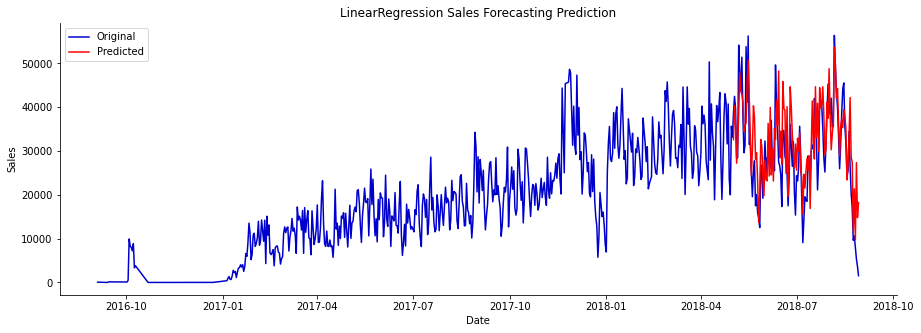

In [ ]:
run_model(train, test, LinearRegression(), 'LinearRegression')

RMSE: 6982.816854326236
MAE: 5683.829416666665
R2 Score: 0.598292224916607


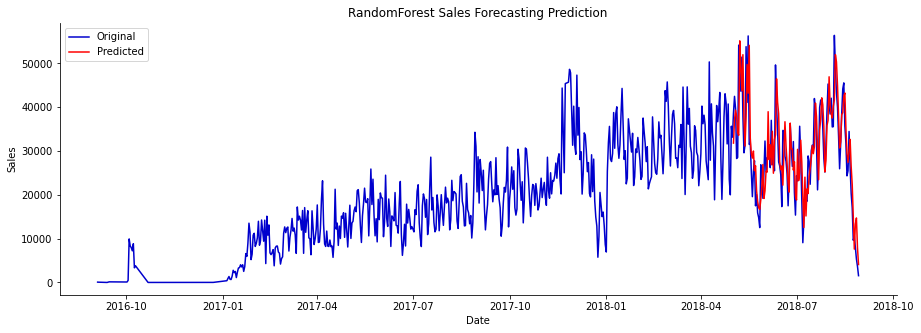

In [ ]:
run_model(train, test, RandomForestRegressor(n_estimators=100, max_depth=20), 'RandomForest')

RMSE: 7392.699045898541
MAE: 6042.953916666663
R2 Score: 0.5497486871652202


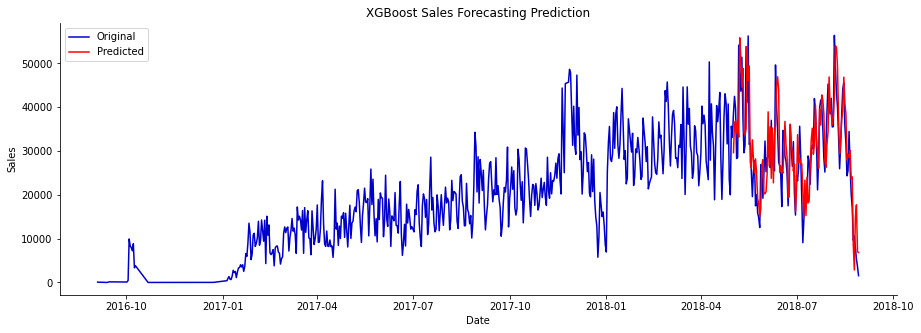

In [ ]:
run_model(train, test, XGBRegressor( n_estimators=100, 
                                    learning_rate=0.2, 
                                    objective='reg:squarederror'), 'XGBoost')

In [ ]:
results_df = pd.DataFrame(model_scores, index=['RSME', 'MAE', 'R2 Score'])
results_df = results_df.transpose().reset_index().rename(columns={'index':'Model'})
results_df

,Model,RSME,MAE,R2 Score
0,LinearRegression,8024.686734,6254.150583,0.469476
1,RandomForest,6982.816854,5683.829417,0.598292
2,XGBoost,7392.699046,6042.953917,0.549749


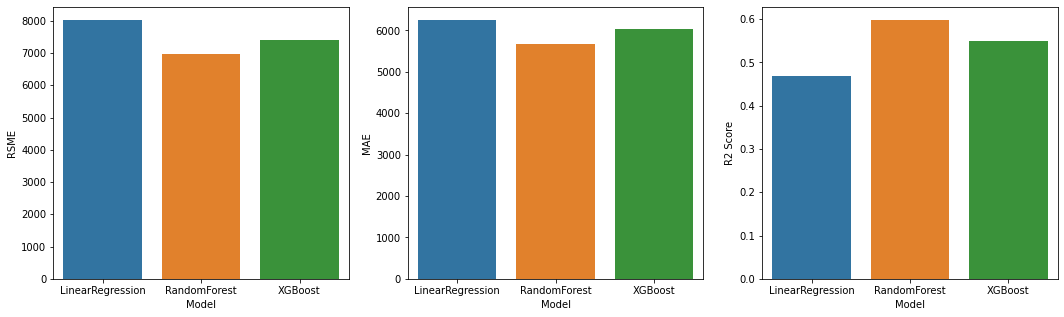

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.barplot(x='Model', y='RSME', data=results_df, ci=1, ax=axes[0])
sns.barplot(x='Model', y='MAE', data=results_df,  ci=1, ax=axes[1])
sns.barplot(x='Model', y='R2 Score', data=results_df, ci=1, ax=axes[2])
plt.show()

## **Goal 2: Product Scoring**

---



**Top 5 Records Of Final Structured Data**

In [ ]:
final_data.head()

,order_id,cust_id,ord_timestamp,ord_date,ord_yr_month,ord_yr,cust_unique_id,cust_zip_code_prefix,cust_city,cust_state,cust_group,review_id,review_score,c,order_item_id,pid,price,freight_value,product_name
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02,2017-10,2017,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,Regular Buyer,a54f0611adc9ed256b57ede6b6eb5114,4,1,1.0,87285b34884572647811a353c7ac498a,29.99,8.72,housewares
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-07-24,2018-07,2018,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,One Time Buyer,8d5266042046a06655c8db133d120ba5,4,1,1.0,595fac2a385ac33a80bd5114aec74eb8,118.70,22.76,perfumery
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-08,2018-08,2018,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,One Time Buyer,e73b67b67587f7644d5bd1a52deb1b01,5,1,1.0,aa4383b373c6aca5d8797843e5594415,159.90,19.22,auto
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017-11-18,2017-11,2017,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,One Time Buyer,359d03e676b3c069f62cadba8dd3f6e8,5,1,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,45.00,27.20,pet_shop
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018-02-13,2018-02,2018,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,One Time Buyer,e50934924e227544ba8246aeb3770dd4,5,1,1.0,65266b2da20d04dbe00c5c2d3bb7859e,19.90,8.72,stationery


### **Step 1:** Selecting required columns for product scoring and creating new dataframe `scoring_df` out of it.


In [ ]:
scoring_df = final_data[['order_id', 'ord_date',
                         'ord_yr_month', 'ord_yr',
                         'pid', 'product_name']].dropna(axis=0)

Checking for null values in the dataframe.

In [ ]:
scoring_df.isna().sum()

order_id        0
ord_date        0
ord_yr_month    0
ord_yr          0
pid             0
product_name    0
dtype: int64

### **Step 2:** Creating function `calculate_score`.<br>
This function will be used to calculate the product scores at different levels.
<br>Different levels are:
* Daily
* Monthly
* Yearly

Parameter `multiplier` is the weightage given to the respective level. 

In [ ]:
def calculate_score(level, multiplier=1):
  if level == 'daily':
    col = 'ord_date'
    op = 'daily_score'
  if level == 'monthly':
    col = 'ord_yr_month'
    op = 'monthly_score'
  if level == 'yearly':
    col = 'ord_yr'
    op = 'yearly_score' 

  df = scoring_df.groupby(by = [col, 'pid', 'product_name'])[['pid']].count().rename(
      columns={'pid':level+'_pid_count'}).sort_values(
          by=[col,level+'_pid_count'], ascending=[True,False]).reset_index()

  df = pd.merge(df, df.groupby(by = [col])[[level+'_pid_count']].max().rename(
      columns={level+'_pid_count':'max_val'}).reset_index(), on=col)
  
  df = pd.merge(df, df.groupby(by = [col])[[level+'_pid_count']].min().rename(
        columns={level+'_pid_count':'min_val'}).reset_index(), on=col)
  
  df[op] = (df[level+'_pid_count'] - df['min_val'])/(
      df['max_val'] - df['min_val'])
  
  df[op] = df[op].replace(np.NaN, 1)*multiplier
  
  df.drop(columns=['min_val', 'max_val'], inplace=True)

  return df

**Daily Scores**

In [ ]:
daily_grp = calculate_score('daily')
daily_grp.head()

,ord_date,pid,product_name,daily_pid_count,daily_score
0,2016-09-04,c1488892604e4ba5cff5b4eb4d595400,furniture_decor,1,1.0
1,2016-09-04,f293394c72c9b5fafd7023301fc21fc2,furniture_decor,1,1.0
2,2016-09-05,f3c2d01a84c947b078e32bbef0718962,telephony,1,1.0
3,2016-09-15,5a6b04657a4c5ee34285d1e4619a96b4,health_beauty,3,1.0
4,2016-10-02,d2998d7ced12f83f9b832f33cf6507b6,baby,1,1.0


**Monthly Scores**

In [ ]:
monthly_grp = calculate_score('monthly', 30)
monthly_grp.head(5)

,ord_yr_month,pid,product_name,monthly_pid_count,monthly_score
0,2016-09,5a6b04657a4c5ee34285d1e4619a96b4,health_beauty,3,30.0
1,2016-09,c1488892604e4ba5cff5b4eb4d595400,furniture_decor,1,0.0
2,2016-09,f293394c72c9b5fafd7023301fc21fc2,furniture_decor,1,0.0
3,2016-09,f3c2d01a84c947b078e32bbef0718962,telephony,1,0.0
4,2016-10,eba7488e1c67729f045ab43fac426f2e,perfumery,11,30.0


**Yearly Scores**

In [ ]:
yearly_grp = calculate_score('yearly', 365)
yearly_grp.head(5)

,ord_yr,pid,product_name,yearly_pid_count,yearly_score
0,2016,eba7488e1c67729f045ab43fac426f2e,perfumery,11,365.0
1,2016,bdcec8e22b04a8f4241d87bcfe9ea877,furniture_decor,6,182.5
2,2016,d9894482fba41f536a273ba2276d951f,market_place,6,182.5
3,2016,473795a355d29305c3ea6b156833adf5,perfumery,5,146.0
4,2016,79938780eb7ffb7289f59a9a283bc06b,health_beauty,5,146.0


### **Step 3**
Combining The Scores Into Single Dataframe.

In [ ]:
scores_df = pd.merge(
    yearly_grp.groupby(['pid', 'product_name'])[['yearly_score']].sum().reset_index(),
    pd.merge(
        monthly_grp.groupby(['pid'])[['monthly_score']].sum().reset_index(),
         daily_grp.groupby(['pid'])[['daily_score']].sum().reset_index(), on='pid'),
         on='pid')

In [ ]:
scores_df['total_score'] = scores_df['yearly_score'] + scores_df['monthly_score'] + scores_df['daily_score']
scores_df.head()

,pid,product_name,yearly_score,monthly_score,daily_score,total_score
0,00066f42aeeb9f3007548bb9d3f33c38,perfumery,0.000000,0.000000,0.0,0.000000
1,00088930e925c41fd95ebfe695fd2655,auto,0.000000,0.000000,0.0,0.000000
2,0009406fd7479715e4bef61dd91f2462,bed_bath_table,0.000000,0.000000,0.0,0.000000
3,000b8f95fcb9e0096488278317764d19,housewares,0.885922,0.447761,0.0,1.333684
4,000d9be29b5207b54e86aa1b1ac54872,watches_gifts,0.000000,0.000000,0.0,0.000000


### **Step 4**
Normalizing the score and plotting.<br> The function `normalize` scales the score in the range of 0 to 100. 


In [ ]:
def normalize(df, level, top=5):
  df1 = df.groupby('product_name')[[level+'_score']].sum().sort_values(
      level+'_score', ascending=False).reset_index()
  
  max_val = df1[level+'_score'].max()
  min_val = df1[level+'_score'].min()

  df1[level+'_score_norm'] = (df1[level+'_score'] - min_val)/(max_val - min_val)
  df1[level+'_score_norm'] = round(df1[level+'_score_norm'].replace(
      np.NaN, 1)*100, 2)
  df1.index = np.arange(1, len(df1) + 1)
  return df1.head(top)

**Product Scoring At Day Level**

In [ ]:
normalize(scores_df,'daily', 10)[['product_name', 'daily_score_norm']]

,product_name,daily_score_norm
1,furniture_decor,100.00
2,bed_bath_table,91.56
3,computers_accessories,83.73
4,health_beauty,81.26
5,garden_tools,62.77
6,housewares,59.03
7,sports_leisure,58.46
8,watches_gifts,43.34
9,telephony,29.03
10,cool_stuff,25.09


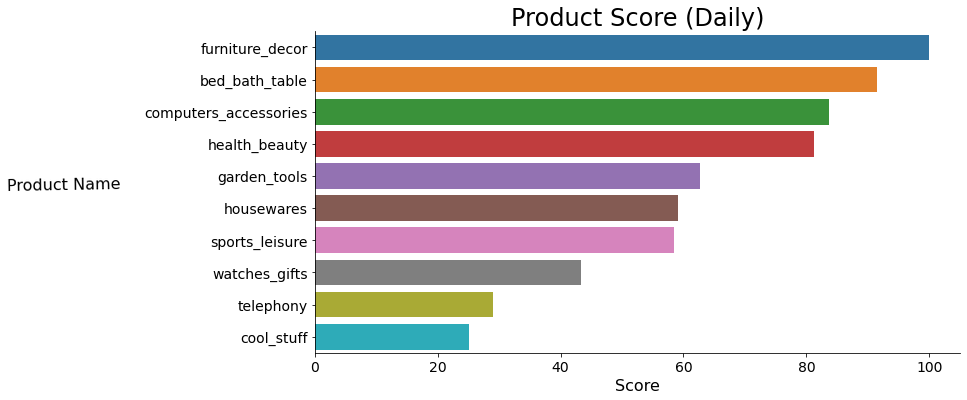

In [ ]:
dplot = sns.catplot(y='product_name', x='daily_score_norm',
                    data=normalize(scores_df,'daily', 10), ci=1, kind='bar')
dplot.fig.set_size_inches(15,5)
ax=dplot.ax
ax.set_ylabel('Product Name',size=16, rotation=1,labelpad=80)
ax.set_xlabel('Score',size=16)
ax.tick_params(labelsize=14)
ax.set_title('Product Score (Daily)', size=24)
plt.show()

**Product Scoring At Month Level**

In [ ]:
normalize(scores_df,'monthly', 10)[['product_name', 'monthly_score_norm']]

,product_name,monthly_score_norm
1,health_beauty,100.00
2,bed_bath_table,93.57
3,computers_accessories,76.95
4,furniture_decor,71.86
5,sports_leisure,62.63
6,garden_tools,56.36
7,watches_gifts,54.51
8,housewares,53.52
9,telephony,42.56
10,cool_stuff,37.28


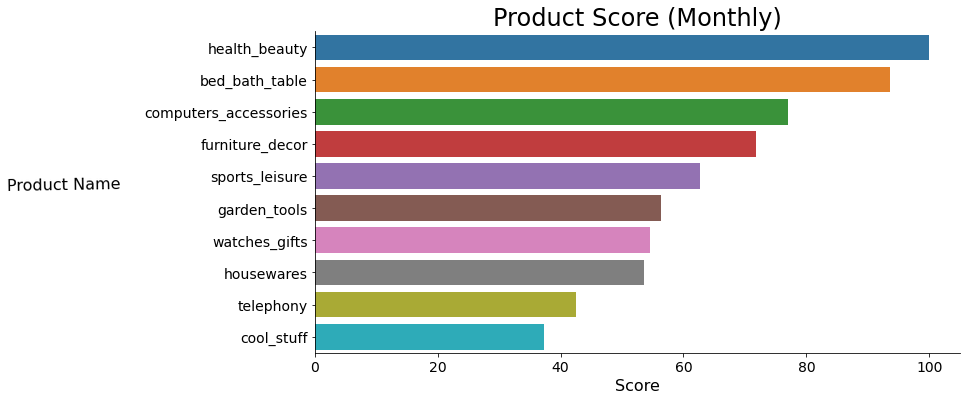

In [ ]:
mplot = sns.catplot(y='product_name', x='monthly_score_norm',
                    data=normalize(scores_df,'monthly', 10), ci=1, kind='bar')
mplot.fig.set_size_inches(15,5)
ax=mplot.ax
ax.set_ylabel('Product Name',size=16, rotation=1,labelpad=80)
ax.set_xlabel('Score',size=16)
ax.tick_params(labelsize=14)
ax.set_title('Product Score (Monthly)', size=24)
plt.show()

**Product Scoring At Year Level**

In [ ]:
normalize(scores_df,'yearly', 10)[['product_name', 'yearly_score_norm']]

,product_name,yearly_score_norm
1,bed_bath_table,100.00
2,health_beauty,98.12
3,furniture_decor,78.46
4,computers_accessories,76.88
5,sports_leisure,69.25
6,housewares,58.05
7,watches_gifts,55.79
8,garden_tools,45.90
9,telephony,41.73
10,perfumery,39.71


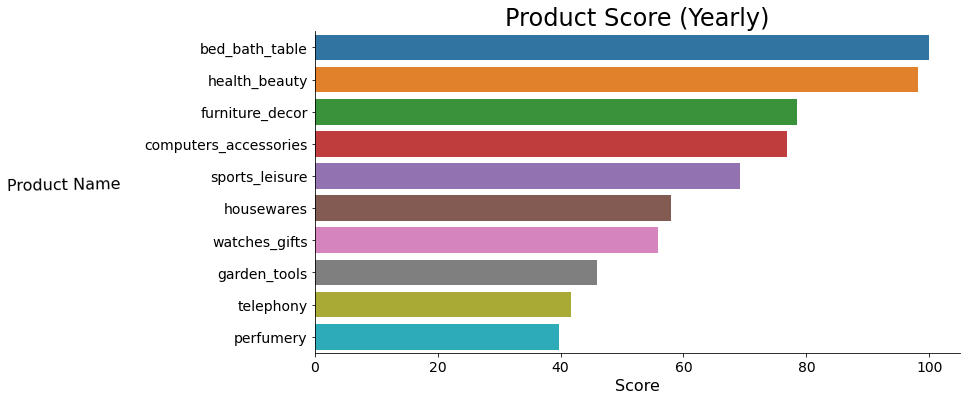

In [ ]:
yplot = sns.catplot(y='product_name', x='yearly_score_norm',
                    data=normalize(scores_df,'yearly', 10), ci=1, kind='bar')
yplot.fig.set_size_inches(15,5)
ax=yplot.ax
ax.set_ylabel('Product Name',size=16, rotation=1,labelpad=80)
ax.set_xlabel('Score',size=16)
ax.tick_params(labelsize=14)
ax.set_title('Product Score (Yearly)', size=24)
plt.show()

**Final Product Scores**

In [ ]:
normalize(scores_df,'total', 10)[['product_name', 'total_score_norm']]

,product_name,total_score_norm
1,bed_bath_table,100.00
2,health_beauty,99.95
3,furniture_decor,79.36
4,computers_accessories,78.88
5,sports_leisure,68.43
6,housewares,58.11
7,watches_gifts,56.05
8,garden_tools,50.53
9,telephony,42.26
10,perfumery,38.74


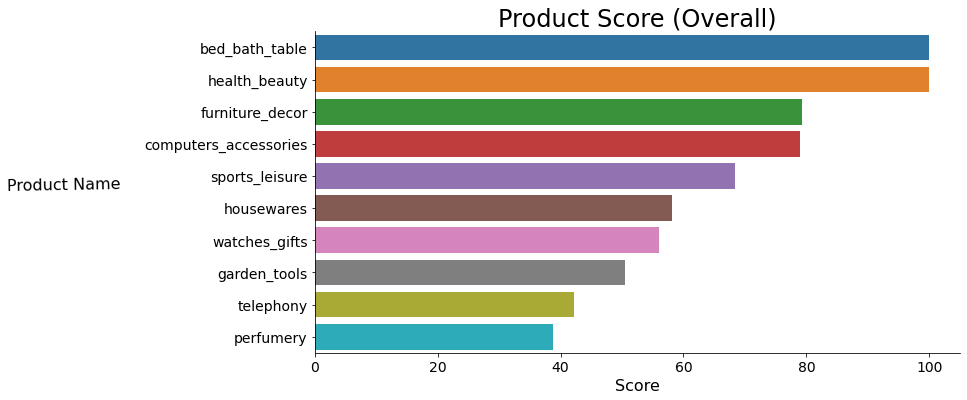

In [ ]:
oplot = sns.catplot(y='product_name', x='total_score_norm',
                    data=normalize(scores_df,'total', 10), ci=1, kind='bar')
oplot.fig.set_size_inches(15,5)
ax=oplot.ax
ax.set_ylabel('Product Name',size=16, rotation=1,labelpad=80)
ax.set_xlabel('Score',size=16)
ax.tick_params(labelsize=14)
ax.set_title('Product Score (Overall)', size=24)
plt.show()